In [1]:
import pandas
import numpy as np
import matplotlib as mlp
import seaborn
import matplotlib.pyplot as plt
from statistics import mean
from tqdm.notebook import tqdm
from IPython.display import display
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
pandas.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# To make sure that all runs are similar + 
# Seed helps us to make sure we have the same train and test sets as it is in training notebook
RAND_SEED = 6758

# Proportion of dataset to be considered as Test set
SPLIT = 0.4 

# Selected features
features = ['comments','empty_comments','clusters','gini']

## Load and split date

In [3]:
df_orig = pandas.read_csv('../data/accounts.csv.gz')

## Create same train and test set as the one we used in classification notebook

In [4]:
from sklearn.model_selection import train_test_split 

df = (
    # Having a copy of original data
    df_orig.copy()
    .reset_index()
)

def train_test_split(dataframe, test_split=.4, random_state=123):
    # Set of bots
    bots = df[lambda x: x['bot']==1 ]
    # Set of humans
    humans = df[lambda x: x['bot']==0 ]

    # Split of bots for the test set
    df_test_bot = bots.sample(round(SPLIT *len(bots)),random_state=RAND_SEED)
    # Split of bots for the train set
    df_train_bot = df.iloc[bots[lambda x: ~bots.index.isin(df_test_bot.index)].index]

    # Split of humans for the test set
    df_test_human = humans.sample(round(SPLIT *len(humans)),random_state=RAND_SEED)
    # Split of humans for the train set
    df_train_human = df.iloc[humans[lambda x: ~humans.index.isin(df_test_human.index)].index]

    # Create the train set 
    df_train = (pandas.concat([df_train_bot,df_train_human]))
    # Create the test set 
    df_test = (pandas.concat([df_test_human,df_test_bot]))
    
    return df_train,df_test

df_train, df_test = train_test_split(df,test_split=SPLIT,random_state=RAND_SEED)

## Load model 

In [5]:
import pickle

filename = "../model.pkl"

with open(filename, 'rb') as file:
    model = pickle.load(file)

## Evaluate model on test data

In [6]:
from sklearn.metrics import classification_report 
print(classification_report(df_test['bot'].values,model.predict(df_test[features].values)))

testres = (
    df_test.assign(predict = lambda x: model.predict(x[features]))
)
trainres = (
    df_train.assign(predict = lambda x: model.predict(x[features]))
)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1789
           1       0.94      0.91      0.92       211

    accuracy                           0.98      2000
   macro avg       0.96      0.95      0.96      2000
weighted avg       0.98      0.98      0.98      2000



## Statistics

In [7]:
print("Wrongly classified in the test set:")
print("\tbots identified as human",len(testres.query('bot != predict & predict == 0 & bot == 1')))
print("\thuman identified as bot",len(testres.query('bot != predict & predict == 1 & bot == 0')))

print("\nCorrectly classified in the test set:")
print("\tcorrectly classified bots",len(testres.query('bot == predict & predict == 1')))
print("\tcorrectly classified humans",len(testres.query('bot == predict & predict == 0')))

Wrongly classified in the test set:
	bots identified as human 19
	human identified as bot 13

Correctly classified in the test set:
	correctly classified bots 192
	correctly classified humans 1776


In [8]:
print("Wrongly classified in the training set:")
print("\tbots identified as human",len(trainres.query('bot != predict & predict == 0 & bot == 1')))
print("\thuman identified as bot", len(trainres.query('bot != predict & predict == 1 & bot == 0')))

print("\nCorrectly classified in the training set:")
print("\tcorrectly classified bots",len(trainres.query('bot == predict & predict == 1')))
print("\tcorrectly classified humans",len(trainres.query('bot == predict & predict == 0')))

Wrongly classified in the training set:
	bots identified as human 5
	human identified as bot 4

Correctly classified in the training set:
	correctly classified bots 311
	correctly classified humans 2680


## Sensitivity analysis

In [9]:
from sklearn.metrics import confusion_matrix

# To predict the given row with our model
def perdict_account(model,row):
    return model.predict(row[features].values)

hyper_tuning=pandas.DataFrame()
# Create a column with number of non-empty comments
df = (
    df_test
    .copy().
    assign(nonempty_comments = lambda x: x['comments']-x['empty_comments'])
    .assign(pred = lambda x: perdict_account(model,x).astype(int))
)

# Bin size
binv = 5

# Calculate number of TP, FP, TN, FN in each bin
for lim in range(0,100,binv):
    true= df[lambda x:x['nonempty_comments'] >= lim][lambda x:x['nonempty_comments'] < lim+binv]['bot']
    pred= df[lambda x:x['nonempty_comments'] >= lim][lambda x:x['nonempty_comments'] < lim+binv]['pred']
    cnf = confusion_matrix(true,pred)
    hyper_tuning=hyper_tuning.append({
        'critrion':'max_nonempty_comment',
        'model': str(model).split('(')[0],
        'lim':lim,
        'total':len(true),
        'TP': cnf[0][0] if len(cnf) >0 else 0,
        'FP': cnf[0][1] if len(cnf) >1 else 0,
        'FN': cnf[1][0] if len(cnf) >1 else 0,
        'TN': cnf[1][1] if len(cnf) >1 else 0,
    },ignore_index=True)

# Function to calculate F1
def wf1(TP,FN,TN,FP):
    try:
        wp = (((TP/(TP+FP))*(TP+FN)) + ((TN/(TN+FN))*(TN+FP))) / (TP+FN+TN+FP)
        wr = (((TP/(TP+FN))*(TP+FN)) + ((TN/(TN+FP))*(TN+FP))) / (TP+FN+TN+FP)
        return (2*wp*wr)/(wp+wr)
    except ZeroDivisionError:
        return 0

# Apply F1 for each row
hyper_tuning['wf'] = hyper_tuning.apply(lambda x: wf1(x['TP'],x['FN'],x['TN'],x['FP']),axis=1)
hyper_tuning = (
    hyper_tuning
    .assign(lim = lambda x: x['lim'].astype(int))
    .reset_index()
    .set_index('lim')
)


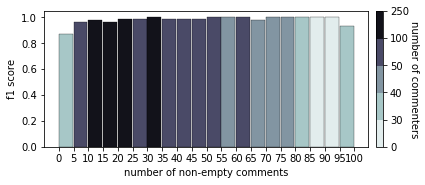

In [10]:
from matplotlib.colors import LinearSegmentedColormap

colors= seaborn.color_palette("bone_r", 11)
fig, ax = plt.subplots(figsize=[7,2.5])

# Set color for each row
def returncolor(num):
    if num<=30 :
        return colors[0]
    elif num<=40:
        return colors[2]
    elif num<=50:
        return colors[4]
    elif num<=100:
        return colors[7]
    else:
        return colors[10]
    
# Find color for each bin based on number of commenter in each row
df = hyper_tuning.assign(c = lambda x: x['total'].apply(lambda s : returncolor(s)))

# Draw hist 
for i,row in df.iterrows():
    ax.bar(i, row['wf'], width=4.7,linewidth=.3, color=row['c'], align='edge',edgecolor='k')

# Create color map
myColors = (colors[0], colors[2], colors[4],colors[7],colors[10])
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
colorbar = fig.colorbar(mlp.cm.ScalarMappable(norm=mlp.colors.Normalize(vmin=0,vmax=250), cmap=cmap), ax=ax,pad = 0.02)
plt.xticks(range(0,101,5))
colorbar.set_ticks([0, 50, 100,150,200,250])
colorbar.set_ticklabels([0, 30,40,50,100,250])
colorbar.ax.text(1200,20,'number of commenters', rotation=270)
ax.set_ylabel('f1 score')
ax.set_xlabel('number of non-empty comments')
fig.savefig('../figures/sensitivity_analysis_wf1.pdf', bbox_inches='tight')

In [11]:
(
    df_orig
    .assign(prediction = lambda x: model.predict(x[features]))
    [['account','project','bot','prediction']]
    .to_csv('../data/predictions.csv.gz')
)